In [9]:
from __future__ import division
#locations, locations
#Georgi's CISBP list grepped for SPI1:
spi1_cisbp_hits = "/home/ktian/kundajelab/tfnet/results/nandi/CIS-BP/data/SPI1.txt"
#1kb around SPI1 GM12878 summits:
spi1_summits_and_flank_coords = "/srv/scratch/ktian/kundajelab/tfmodisco_bio_experiments/results/nandi/SPI1/SPI1_GM12878_18_08_31/interpret.tsv"
spi1_summits_and_flank_fa = "/srv/scratch/ktian/kundajelab/tfmodisco_bio_experiments/results/nandi/SPI1/SPI1_GM12878_18_08_31/interpret.fa"
hyp_scores = "/home/ktian/kundajelab/tfnet/results/nandi/SPI1/SPI1_GM12878_refine_18_09_04/scores/hyp_scores_task_0.npy"
spi1_bqtls = "/home/ktian/kundajelab/tfnet/results/nandi/bQTL/analysis/bQTL_all_SNPs/SPI1.txt"

In [5]:
import numpy as np
pwm_name_to_matrix = {
    "M6119_1.02": np.array([
[0.441926,0.141643,0.325779,0.090652],
[0.66289,0.045326,0.25779,0.033994],
[0.875354,0.0,0.076487,0.048159],
[0.864023,0.0,0.07932,0.056657],
[0.733711733711734,0.0,0.0311610311610312,0.235127235127235],
[0.124646,0.031161,0.838527,0.005666],
[0.640227,0.062323,0.29745,0.0],
[0.073654,0.0,0.926346,0.0],
[0.0,0.0,1.0,0.0],
[0.994334,0.005666,0.0,0.0],
[1.0,0.0,0.0,0.0],
[0.014164,0.172805,0.810198,0.002833],
[0.050991949008051,0.0198299801700198,0.0254959745040255,0.903682096317904],
[0.00566599433400566,0.0906519093480906,0.878186121813878,0.0254959745040255],
[0.288952,0.223796,0.402266,0.084986]])}

In [108]:
from collections import defaultdict

##filter the SPI1 bQTLs for the ones that are in the 1kb summits
spi1_bqtls_in_1kb = "spi1_bqtls_in_1kb.txt"
! ./filter_bqtls_to_be_in_region.sh $spi1_bqtls $spi1_summits_and_flank_coords > $spi1_bqtls_in_1kb

In [ ]:
from collections import defaultdict, namedtuple
import numpy as np

#read in all the region coordinates and create a map from coordinate to index
region_coord_to_idx = {}
for i,line in enumerate(open(spi1_summits_and_flank_coords)):
    chrom,start,end = line.rstrip().split("\t")
    region_coord_to_idx[chrom+":"+start+"-"+end] = i
total_regions = max(coord_to_idx.values())+1

BQTL = namedtuple("BQTL", ["chrom", "chrom_start", "region_idx", "offset", "alt_allele", "post_allele", "pval"])
    
region_idx_to_bqtls = defaultdict(list)
all_bqtls = []
    
#read in all the bqtl info, get the bQTL coordinates relative to the region starts
for line in open(spi1_bqtls_in_1kb):
    bqtl_chrom,bqtl_start,bqtl_end,alt_allele,post_allele,pval,region_chrom,region_start,region_end = line.rstrip().split("\t")
    bqtl_start = int(bqtl_start)
    bqtl_end = int(bqtl_end)
    pval = float(pval)
    region_idx = region_coord_to_idx[region_chrom+":"+region_start+"-"+region_end]
    region_start = int(region_start)
    region_end = int(region_end)    
    offset_from_start = bqtl_start-region_start
    assert bqtl_chrom==region_chrom
    assert offset_from_start >= 0 and offset_from_start <= 1000
    bqtl = BQTL(chrom=bqtl_chrom, chrom_start=bqtl_start,
                region_idx=region_idx, offset=offset_from_start,
                alt_allele=alt_allele, post_allele=post_allele, pval=pval)
    all_bqtls.append(bqtl)
    region_idx_to_bqtls[region_idx].append(bqtl)

#read in the hyp contribs
hypcontribs = np.load(hyp_scores)
assert len(hypcontribs)==total_regions

In [156]:
#get the hyp contrib predicted delta
bqtl_hypcontrib_delta = []
bqtl_position_max_delta = []
bqtl_nearby_importance = []
bqtl_neglog10_pvalues = []
letter_to_idx = {'A':0, 'C':1, 'G':2, 'T':3}
for bqtl in all_bqtls:
    #if (abs(bqtl.offset - 500) > 200):
    alt_letter_idx = letter_to_idx[bqtl.alt_allele]
    post_letter_idx = letter_to_idx[bqtl.post_allele]
    bqtl_hypcontrib_delta.append(hypcontribs[bqtl.region_idx, bqtl.offset, post_letter_idx]
                                 - hypcontribs[bqtl.region_idx, bqtl.offset, alt_letter_idx])
    bqtl_position_max_delta.append(np.max(hypcontribs[bqtl.region_idx, bqtl.offset])
                                   - np.min(hypcontribs[bqtl.region_idx, bqtl.offset]))
    bqtl_nearby_importance.append(np.sum(np.abs(hypcontribs[bqtl.region_idx, bqtl.offset-10:bqtl.offset+10])))
    bqtl_neglog10_pvalues.append(-np.log(bqtl.pval)/np.log(10))
bqtl_hypcontrib_delta = np.array(bqtl_hypcontrib_delta)
bqtl_position_max_delta = np.array(bqtl_position_max_delta)
bqtl_nearby_importance = np.array(bqtl_nearby_importance)
bqtl_neglog10_pvalues = np.array(bqtl_neglog10_pvalues)

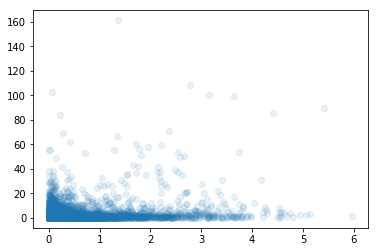

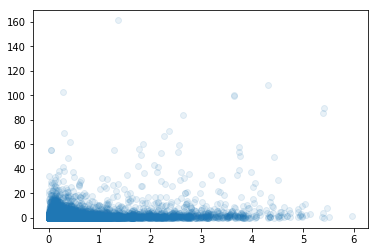

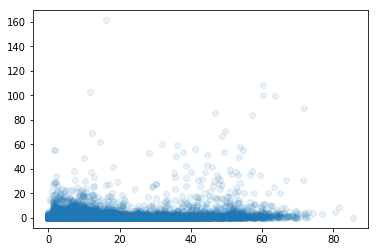

In [157]:
#plot p value versus hyp contrib predicted delta
%matplotlib inline
from matplotlib import pyplot as plt
plt.scatter(np.abs(bqtl_hypcontrib_delta), bqtl_neglog10_pvalues, alpha=0.1)
plt.show()
plt.scatter(bqtl_position_max_delta, bqtl_neglog10_pvalues, alpha=0.1)
plt.show()
plt.scatter(bqtl_nearby_importance, bqtl_neglog10_pvalues, alpha=0.1)
plt.show()


#filter the CISBP hits for the ones in the 1kb summits
#find high p value SNPs that weren't in CISBP hits
#sort by min(pval rank, hyp contrib delta rank)

In [177]:
def percentile_normalize(vals):
    sorted_vals = sorted(enumerate(vals), key=lambda x: x[1])
    original_ordering = [x[0] for x in sorted_vals]
    sorted_val_percentiles = np.arange(len(sorted_vals))/len(sorted_vals)
    return np.array([x[0] for x in sorted(zip(sorted_val_percentiles,original_ordering), key=lambda x: x[1])])

percnormed_bqtl_hypcontrib_delta = percentile_normalize(np.abs(bqtl_hypcontrib_delta))
percnormed_bqtl_nearby_importance = percentile_normalize(bqtl_nearby_importance)
percnormed_bqtl_neglog10_pvalues = percentile_normalize(bqtl_neglog10_pvalues)
percnormed_min_hypcontrib_nearbyimp_percentile = percentile_normalize(np.minimum(percnormed_bqtl_nearby_importance,
                                                                                 percnormed_bqtl_hypcontrib_delta))

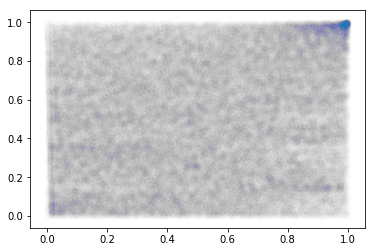

In [181]:
plt.scatter(percnormed_min_hypcontrib_nearbyimp_percentile,
            percnormed_bqtl_neglog10_pvalues, alpha=0.003)
plt.show()

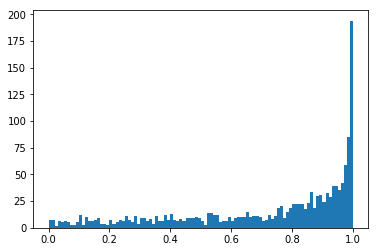

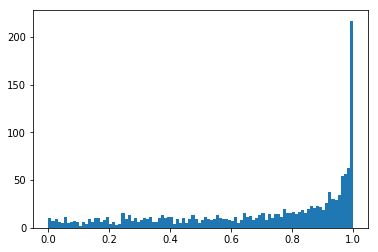

In [195]:
plt.hist(percnormed_min_hypcontrib_nearbyimp_percentile[bqtl_neglog10_pvalues > 4], bins=100)
plt.show()
plt.hist(percnormed_bqtl_hypcontrib_delta[bqtl_neglog10_pvalues > 4], bins=100)
plt.show()

-1.3692088
1.3692088
-1.3692088


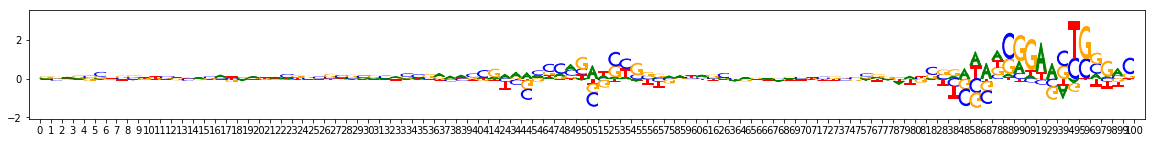

In [154]:
from deeplift.visualization import viz_sequence
import sys

idx = 0
bqtl = all_bqtls[idx]
print(bqtl_hypcontrib_delta[idx])
print(bqtl_position_max_delta[idx])
print(hypcontribs[bqtl.region_idx, bqtl.offset, letter_to_idx[bqtl.post_allele]]
      - hypcontribs[bqtl.region_idx, bqtl.offset, letter_to_idx[bqtl.alt_allele]])
sys.stdout.flush()
viz_sequence.plot_weights(hypcontribs[bqtl.region_idx][bqtl.offset-50:bqtl.offset+50])
